# ECE/CS 434 | MP2: DUET
<br />
<nav>
    <span class="alert alert-block alert-warning">Due on Wednesday Feb 21 11:59PM on Gradescope</span>
   
</nav><br> 


## Objective
In this MP, you will:
- Implement DUET algorithm to separate a mixture of N voice signals from received from two microphones

---
## Problem Overview
Consider a problem of separating N sources ($S_1$, $S_2$, ... $S_N$) from recordings on 2 microphones ($R_1$ and $R_2$).
According to DUET algorithm, you will need to perform the following steps:

- Calculate the short-time Fourier transform of two received signals to get the time-frequency spectrograms
- Calculate the ratio of the two time-frequency spectrograms to get relative delay and attenuation
- Cluster the time-frequency bins in the 2D space spanned by relative delay and attenuation
- Recover the original N signals based on the clustering results

You can refer to the original DUET paper in ICASSP 2000: "Blind separation of disjoint orthogonal signals: demixing N sources from 2 mixtures" and this tutorial in Blind speech separation, 2007 - Springer: "The DUET blind source separation algorithm"

For the sake of easier clustering, the exact number of sources N will be provided to you.

You can assume there is no time-frequency bin collision for any two sources.

---
## Imports & Setup
To run the grading script of this MP, you will need to install the Python [SpeechRecognition](https://pypi.org/project/SpeechRecognition/) package. The SpeechRecognition package also requires the dependency [pocketsphinx](https://pypi.org/project/pocketsphinx/). You may directly use pip install to install both packages.
The following `code` cell, when run, imports the libraries you might need for this MP. Feel free to delete or import other commonly used libraries. Double check with the TA if you are unsure if a library is supported.

In [90]:
import numpy as np
import scipy.io.wavfile
import speech_recognition as sr

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    plt.style.use("seaborn") # This sets the matplotlib color scheme to something more soothing
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')

# This function is used to format test results. You don't need to touch it.
def display_table(data):
    from IPython.display import HTML, display
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

### Sanity-check

Running the following code block verifies that the correct module versions are indeed being used. 

Try restarting the Python kernel (or Jupyter) if there is a mismatch even after intalling the correct version. This might happen because Python's `import` statement does not reload already-loaded modules even if they are updated.

In [91]:
if __name__ == '__main__':
    from IPython.display import display, HTML

    def printc(text, color):
        display(HTML("<text style='color:{};weight:700;'>{}</text>".format(color, text)))

    _requirements = [r.split("==") for r in open(
        "packages.txt", "r").read().split("\n")]

    import sys
    for (module, expected_version) in _requirements:
        try:
            if sys.modules[module].__version__ != expected_version:
                printc("[✕] {} version should to be {}, but {} is installed.".format(
                    module, expected_version, sys.modules[module].__version__), "#f44336")
            else:
                printc("[✓] {} version {} is correct.".format(
                    module, expected_version), "#4caf50")
        except:
            printc("[–] {} is not imported, skipping version check.".format(
                module), "#03a9f4")

---
## Your Implementation
Implement your localization algorithm in the function `duet_source_separation(mic_data_folder, NUM_SOURCES)`. Do **NOT** change its function signature. You are, however, free to define and use helper functions. 

Your implementation for `duet_source_separation` function should **NOT** output any plots or data. It should only return the user's calculated location.

In [94]:
import numpy as np
import scipy.io.wavfile
from scipy.signal import stft, istft, butter, lfilter
from scipy.cluster.vq import kmeans2
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
#import matplotlib.pyplot as plt

def duet_source_separation(mic_data_folder, NUM_SOURCES):
    rate0, data0 = scipy.io.wavfile.read(f'{mic_data_folder}/0.wav')
    rate1, data1 = scipy.io.wavfile.read(f'{mic_data_folder}/1.wav')
    
    assert rate0 == rate1, "Sample rates do not match"
    assert len(data0) == len(data1), "Audio lengths do not match"
    
    # Design a low-pass filter
    cutoff_frequency = 4000  # Cutoff frequency in Hz
    N = 6  # Order of the filter
    Wn = cutoff_frequency / (0.5 * rate0)  # Normalized cutoff frequency
    b, a = butter(N, Wn, btype='low')

    # Apply the low-pass filter to the data
    data0_filtered = lfilter(b, a, data0)
    data1_filtered = lfilter(b, a, data1)
    
    # Example of tuning STFT parameters
    nperseg = 512  # Window size
    noverlap = int(0.75 * nperseg)  # 75% overlap
    window = 'hann'  # Window type

    f, t, Zxx0 = stft(data0_filtered, fs=rate0, nperseg=nperseg, noverlap=noverlap, window=window)
    f, t, Zxx1 = stft(data1_filtered, fs=rate1, nperseg=nperseg, noverlap=noverlap, window=window)



    epsilon = 1e-10

    spec0 = Zxx0[1:,:]
    spec1 = Zxx1[1:,:]

    
    combined_feature = (spec0 + epsilon) / (spec1 + epsilon)
    log_combined_feature = np.log(combined_feature)

    processed_feature = (np.imag(log_combined_feature)) / (-1*(f[1:, None] ))
 
    #features = processed_feature.flatten()
    features = processed_feature.reshape(-1, 1)  # Make it 2D for StandardScaler

    plt.scatter(features, np.zeros_like(features)) # y axis all zeroes
    plt.show()
    centroids, labels = kmeans2(features, NUM_SOURCES, minit='points')  # Use 'points' for initialization
    #centroids, labels = kmeans2(scaled_features, NUM_SOURCES, minit='++', iter=300)  # Use scaled features

    labels = labels.reshape(spec0.shape)
    plt.scatter(features, np.zeros_like(features))
    separated_signals = np.zeros((NUM_SOURCES, data0.shape[0]))
    
    for i in range(NUM_SOURCES):
        mask = np.where(labels == i, 1, 0)
        Zxx_recovered = spec0 * mask
        plt.pcolormesh(np.log(np.abs(Zxx_recovered)+1e-8))
        Zxx_recovered = np.vstack((Zxx0[0,:], Zxx_recovered))
        #Zxx_recovered = np.vstack((Zxx0[0,:], spec0))
        _, recovered_signal = istft(Zxx_recovered, fs=rate0, nperseg=nperseg, noverlap=noverlap, window=window)
        #print(recovered_signal)        
        #smoothed_signal = savgol_filter(recovered_signal, 33, 2)
        window_length = 33 if len(recovered_signal) > 50 else len(recovered_signal) | 1  # Ensure window length is odd and less than signal length
        polyorder = 2  # Might be adjusted based on signal characteristics
        smoothed_signal = savgol_filter(recovered_signal, window_length, polyorder)
        length_diff = separated_signals.shape[1] - len(smoothed_signal)

        if length_diff > 0:
            smoothed_signal_padded = np.pad(smoothed_signal, (0, length_diff), 'constant', constant_values=(0))
            separated_signals[i, :] = smoothed_signal_padded
        else:
            separated_signals[i, :] = smoothed_signal[:separated_signals.shape[1]]

    
    return np.int16(separated_signals)


---
## Running and Testing
Use the cell below to run and test your code, and to get an estimate of your grade.

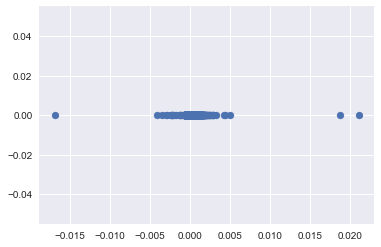

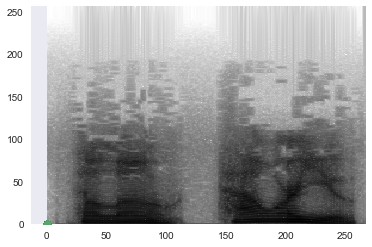

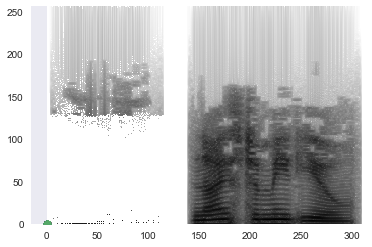

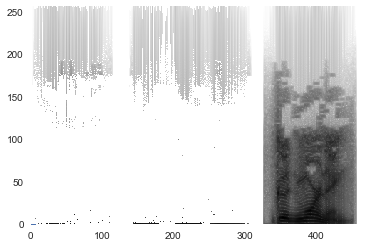

In [95]:

def calculate_score(calculated, expected):
    student_result = set()
    calculated = np.array(calculated)
    if calculated.shape[0] != len(expected):
      return 0, {'Incorrect number of sources!'}
    for i in range(calculated.shape[0]):
        scipy.io.wavfile.write("temp.wav",22050,calculated[i,:])
        r = sr.Recognizer()
        with sr.AudioFile("temp.wav") as source:
            audio = r.record(source)
        try:
            text = r.recognize_sphinx(audio)
            student_result.add(text.lower())
        except:
            student_result.add("Sphinx could not understand audio")
    score = len(student_result.intersection(expected))/len(expected)
    return score, student_result
     
if __name__ == '__main__':
    groundtruth = [{"hello how are you"}, {"nice to meet you","how are you"}, {"how are you","good morning","nice to meet you"}]
    
    output = [['Dataset', 'Expected Output', 'Your Output', 'Grade', 'Points Awarded']]
    for i in range(1,4):
        directory_name = 'dataset{}'.format(i)
        student_output = duet_source_separation(directory_name, i)
        result = calculate_score(student_output, groundtruth[i-1])   
        output.append([
            str(i),
            str(groundtruth[i-1]), 
            str(result[1]), 
            "{:2.2f}%".format(result[0] * 100),
            "{:1.2f} / 5.0".format(result[0] * 5),
        ])

    output.append([
        '<i>👻 Hidden test 1 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    output.append([
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        "<i>...</i>"])
    output.append([
        '<i>👻 Hidden test 7 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    display_table(output)

---
## Rubric
You will be graded on the three data points provided to you (5 points each) and seven additional data points under different settings(10 points each). We will use the same code from the **Running and Testing** section above to grade all 10 traces of data. We will run ASR on your output to see if it generates the corrected separated speech signal. Output order does not matter. Percentage of grade for each data point is based on how many sources you estimated correctly (i.e., assume there are n sources, then you will get $\frac{1}{n} * 100\%$ for each correctedly estimated source).

---
## Submission Guidlines
This Jupyter notebook (`MP2.ipynb`) is the only file you need to submit on Gradescope. As mentioned earlier, you will only be graded using your implementation of the `duet_source_separation` function, which should only return the calculated **NOT** output any plots or data. 

**Make sure any code you added to this notebook, except for import statements, is either in a function or guarded by `__main__`(which won't be run by the autograder). Gradescope will give you immediate feedback using the provided test cases. It is your responsibility to check the output before the deadline to ensure your submission runs with the autograder.**